# Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import missingno as msno
import datetime as dt
import warnings

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [119]:
cirkul = pd.read_csv("cirkuldata.csv")

# Intro EDA/Cleaning

In [120]:
#Both of these need deeper exploration but represent an insanely small fraction, for our analysis we will drop both of these. This takes us from 113,700 to 112,800 and should not impact any larger trends
droppers = ['AmountSpent', 'AcquisitionChannel']
cirkul.dropna(subset=droppers, inplace=True)

In [ ]:
cirkul['InteractionDate'] = pd.to_datetime(cirkul['InteractionDate'])
cirkul['FirstPurchaseDate'] = pd.to_datetime(cirkul['FirstPurchaseDate'])

In [122]:
cirkul['InteractionDate'].min()

Timestamp('2023-01-01 00:00:00')

In [123]:
cirkul['InteractionDate'].max()
#730 day span on data

Timestamp('2024-12-31 00:00:00')

In [124]:
# Filter for dates before 2023-01-05
filtered_df = cirkul.loc[:'2023-01-04']

<Axes: >

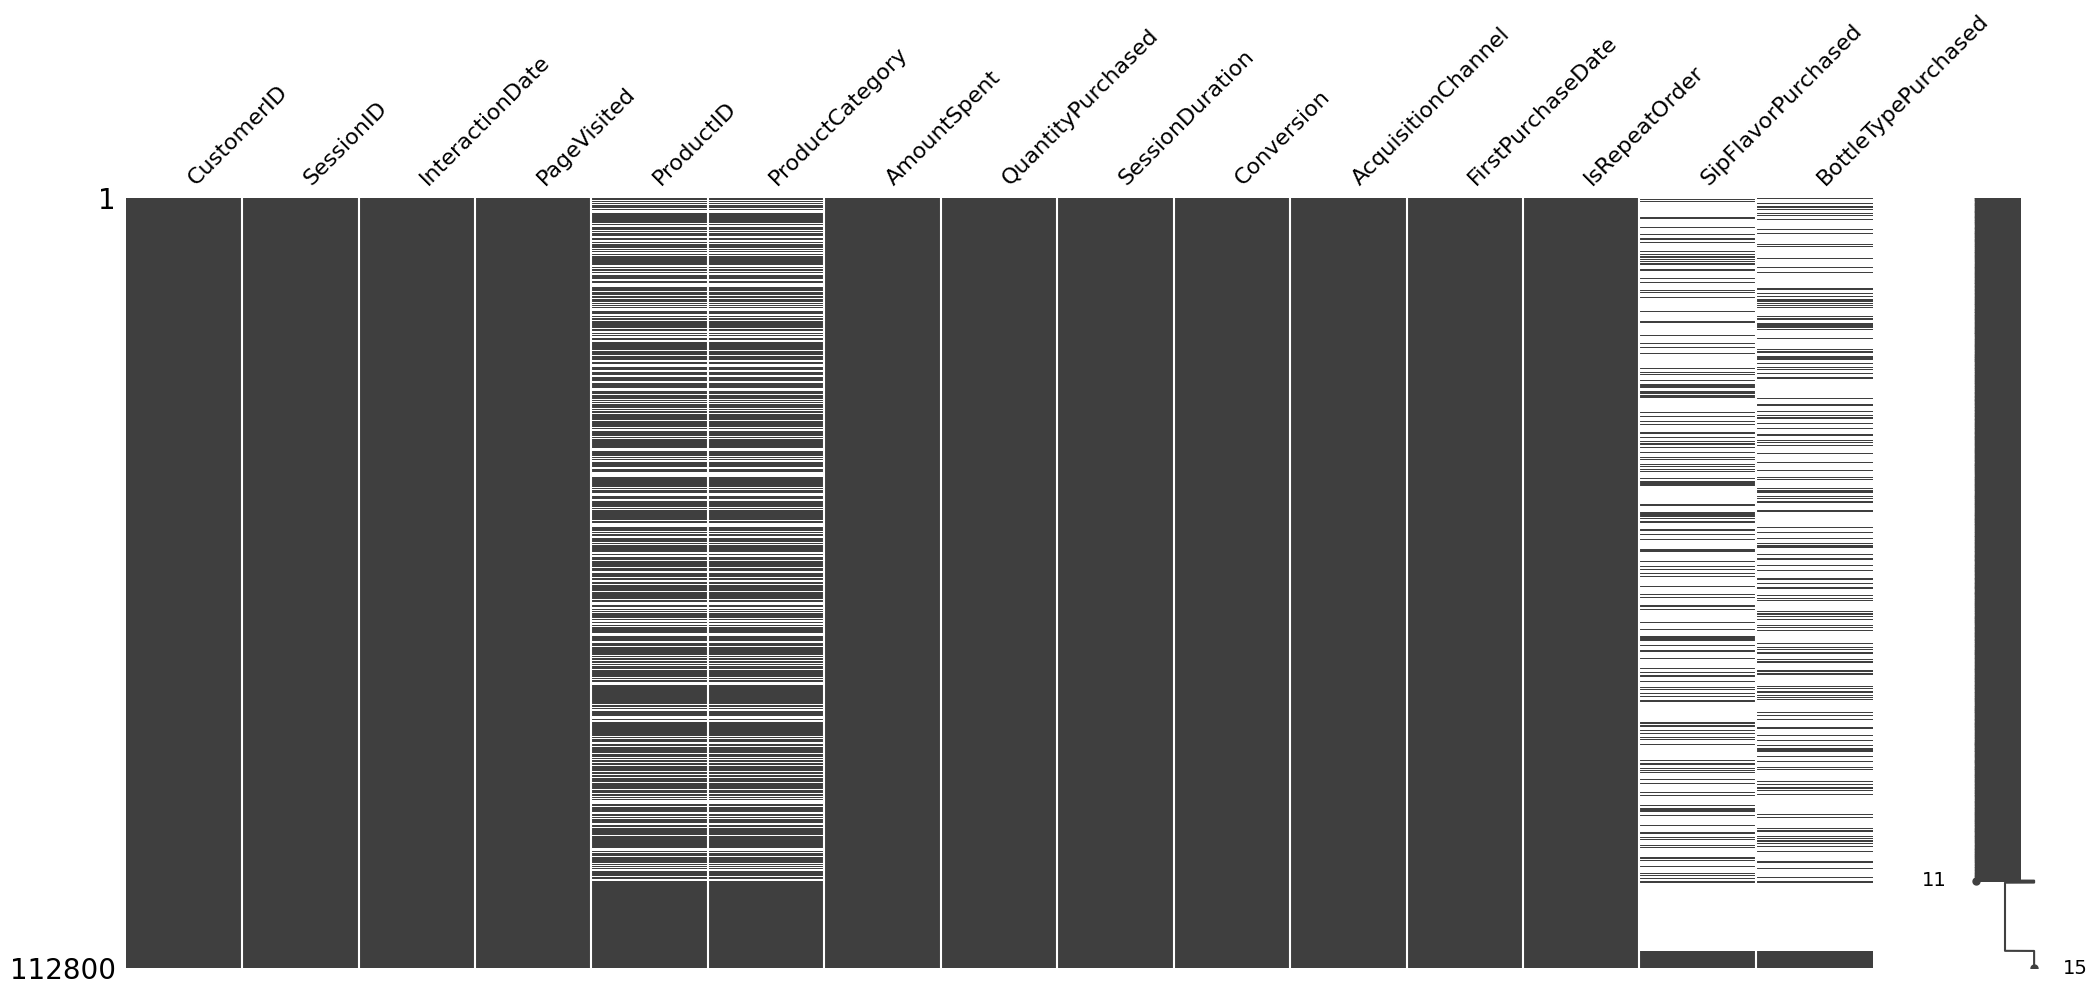

In [125]:
msno.matrix(cirkul)

In [ ]:
#Adds column to breakdown purchase type when more than a single item is purchased, will be used in product choice indicators
cirkul['CombinedPurchase'] = cirkul.apply(
    lambda row: ', '.join([row['SipFlavorPurchased'], row['BottleTypePurchased']])
    if pd.notnull(row['SipFlavorPurchased']) and pd.notnull(row['BottleTypePurchased'])
    else np.nan,
    axis=1
)

In [127]:
cirkul[cirkul['ProductCategory'].isna()]['AmountSpent'].value_counts()
#no weird product IDs

AmountSpent
0.0    33308
Name: count, dtype: int64

In [128]:
cirkul[(cirkul['AmountSpent'] == 0) & (cirkul['QuantityPurchased'] > 0)]
#no freebies to worry about

,CustomerID,SessionID,InteractionDate,PageVisited,ProductID,ProductCategory,AmountSpent,QuantityPurchased,SessionDuration,Conversion,AcquisitionChannel,FirstPurchaseDate,IsRepeatOrder,SipFlavorPurchased,BottleTypePurchased,CombinedPurchase


In [129]:
cirkul[(cirkul['AmountSpent'].notna()) & (cirkul['AmountSpent'].isna())]
#sanity checker, empty both ways

,CustomerID,SessionID,InteractionDate,PageVisited,ProductID,ProductCategory,AmountSpent,QuantityPurchased,SessionDuration,Conversion,AcquisitionChannel,FirstPurchaseDate,IsRepeatOrder,SipFlavorPurchased,BottleTypePurchased,CombinedPurchase


In [130]:
#quick look at data set to the future from when I received this set (5420 rows mostly populated?)
filter_date = pd.to_datetime('2024-11-21')

# cirkul[cirkul['InteractionDate'] > filter_date].sample(10)

# Direct EDA (The good stuff!)

### Monthly Sales Revenue Tracker

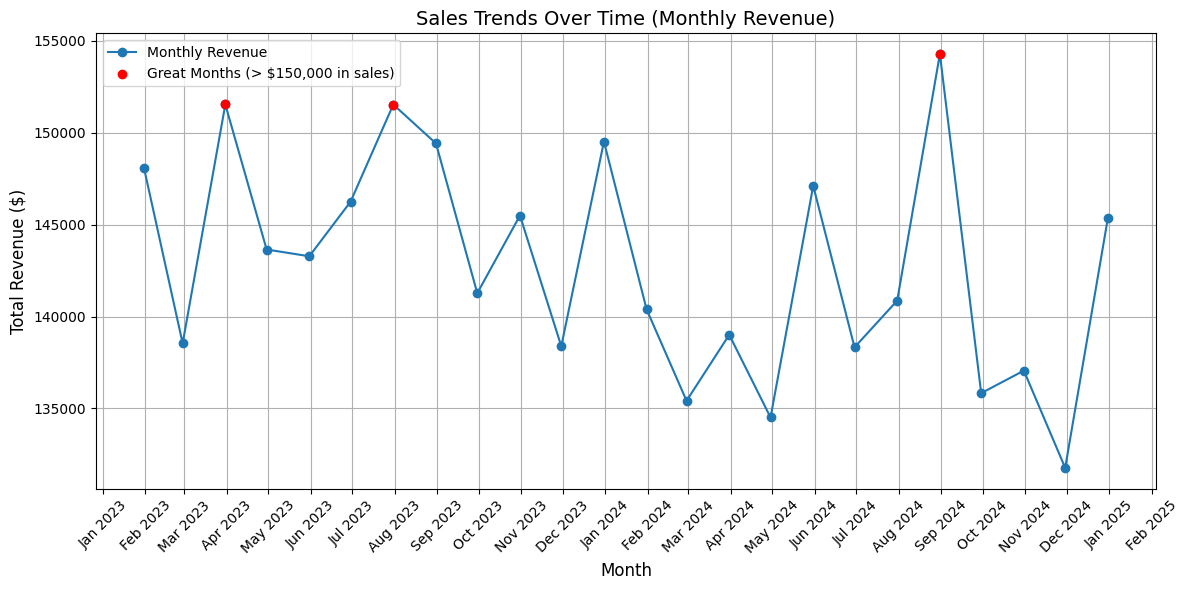

In [ ]:
from scipy.signal import find_peaks #not a bad find!

#Monthly spend aggregation
monthly_revenue = cirkul.resample('ME', on='InteractionDate').agg({'AmountSpent': 'sum'})

#Identify peaks
monthly_revenue['IsPeak'] = monthly_revenue['AmountSpent'] == monthly_revenue['AmountSpent'].max()

peaks, _ = find_peaks(monthly_revenue['AmountSpent'])

#Filter peaks to only include those above a revenue threshold (150,000)
threshold = 150000
high_peaks = peaks[monthly_revenue['AmountSpent'].iloc[peaks] > threshold]

plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index, monthly_revenue['AmountSpent'], marker='o', linestyle='-', label='Monthly Revenue')

plt.scatter(
    monthly_revenue.index[high_peaks], 
    monthly_revenue['AmountSpent'].iloc[high_peaks], 
    color='red', 
    label='Great Months (> $150,000 in sales)', 
    zorder=5
)

#Monthly interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title('Sales Trends Over Time (Monthly Revenue)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Peaks in April of 2023, August of 2023, and most prominently in September of 2024. No obvious correlation to anything special in the calendar but also worth noting there is no insane variance either, the approximate range is ~$24,000. That is to say troughs should not be worried about as much as they may seem visually drastic here. As more time is added to this viz (or if I shrunk this to something like weekly), the graph will likely smooth out.

# First Time vs. Returning Customers by Acquisition Channel

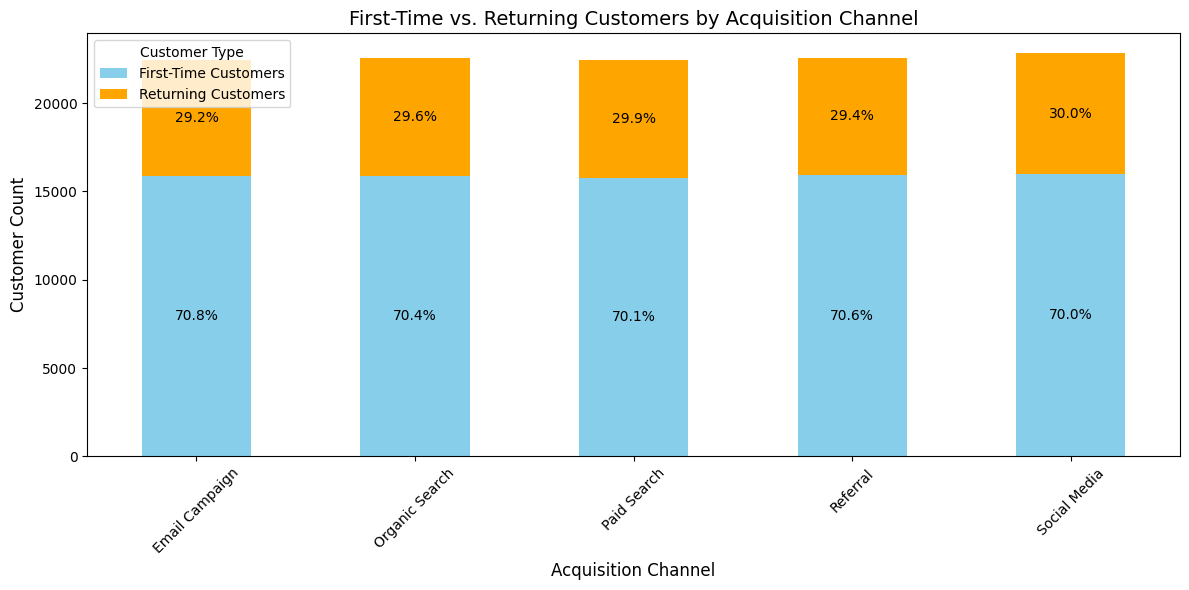

In [132]:
customer_analysis = (
    cirkul.groupby(['AcquisitionChannel', 'IsRepeatOrder'])
        .size()
        .reset_index(name='CustomerCount')
)


#Creating pivot
pivot_channel = customer_analysis.pivot(
    index='AcquisitionChannel', 
    columns='IsRepeatOrder', 
    values='CustomerCount'
)

#Identifier naming
pivot_channel.columns = ['First-Time Customers', 'Returning Customers']

#Make percentages
pivot_channel['Total Customers'] = pivot_channel.sum(axis=1)
pivot_channel['First-Time %'] = (pivot_channel['First-Time Customers'] / pivot_channel['Total Customers']) * 100
pivot_channel['Returning %'] = (pivot_channel['Returning Customers'] / pivot_channel['Total Customers']) * 100

#Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bars = pivot_channel[['First-Time Customers', 'Returning Customers']].plot(
    kind='bar', stacked=True, ax=ax, color=['skyblue', 'orange']
)

#Annotations, finnicky
for i, (ft_percent, rt_percent) in enumerate(zip(pivot_channel['First-Time %'], pivot_channel['Returning %'])):
    ax.text(i, 
            pivot_channel['First-Time Customers'].iloc[i] / 2,
            f"{ft_percent:.1f}%", 
            ha='center', 
            va='center', 
            color='black')
    ax.text(i, 
            pivot_channel['First-Time Customers'].iloc[i] + pivot_channel['Returning Customers'].iloc[i] / 2,
            f"{rt_percent:.1f}%", 
            ha='center', 
            va='center', 
            color='black')

ax.set_title('First-Time vs. Returning Customers by Acquisition Channel', fontsize=14)
ax.set_xlabel('Acquisition Channel', fontsize=12)
ax.set_ylabel('Customer Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

In [133]:
#Print the pivot table for sanity check, seems WEIRDLY uniform
print("\nPivot Table (AcquisitionChannel vs Customer Type):")
print(pivot_channel)


Pivot Table (AcquisitionChannel vs Customer Type):
                    First-Time Customers  Returning Customers  \
AcquisitionChannel                                              
Email Campaign                     15880                 6550   
Organic Search                     15866                 6669   
Paid Search                        15750                 6715   
Referral                           15934                 6622   
Social Media                       15981                 6833   

                    Total Customers  First-Time %  Returning %  
AcquisitionChannel                                              
Email Campaign                22430     70.798038    29.201962  
Organic Search                22535     70.406035    29.593965  
Paid Search                   22465     70.109059    29.890941  
Referral                      22556     70.641958    29.358042  
Social Media                  22814     70.049093    29.950907  


In [ ]:
#Define logic to determine the first purchase item
cirkul['First Purchase Item'] = cirkul.apply(
    lambda row: 'Bottle and Sip Combo'
    if pd.notnull(row['SipFlavorPurchased']) and pd.notnull(row['BottleTypePurchased'])
    else f"{row['SipFlavorPurchased']} Sip"
    if pd.notnull(row['SipFlavorPurchased'])
    else f"{row['BottleTypePurchased']} Bottle"
    if pd.notnull(row['BottleTypePurchased'])
    else pd.NA,
    axis=1
)

#Filter for first purchases
first_purchases = cirkul[cirkul['IsRepeatOrder'] == 0]

#Counts
most_common_first_purchases = first_purchases['First Purchase Item'].dropna().value_counts().reset_index()

#Rename
most_common_first_purchases.columns = ['First Purchase Item', 'Count']

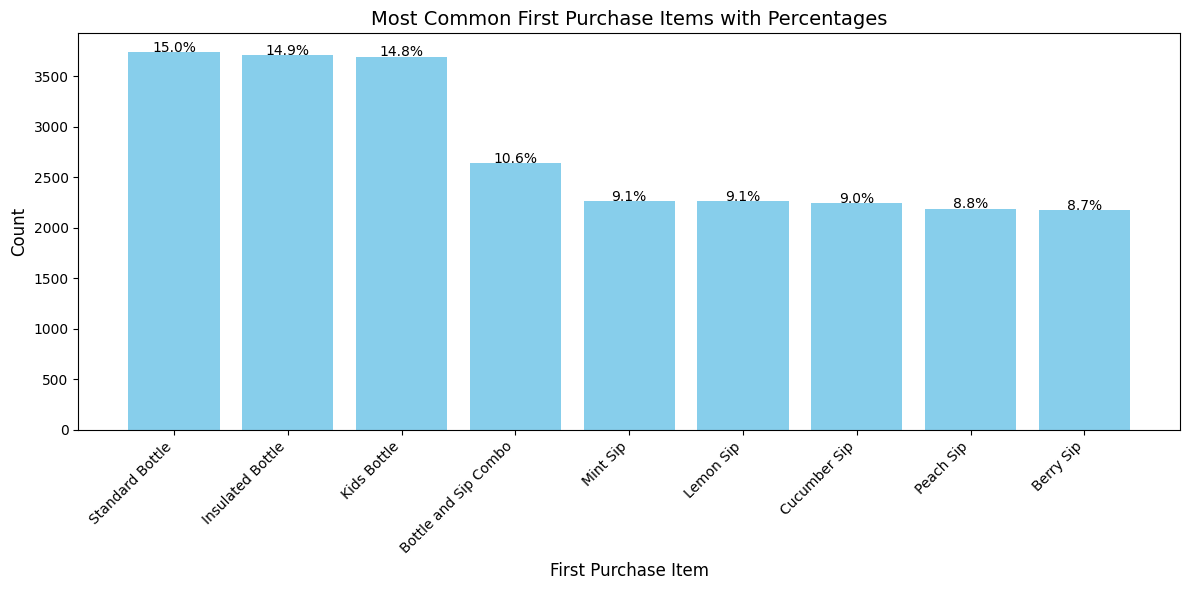

In [ ]:
#percentages
total_first_purchases = most_common_first_purchases['Count'].sum()
most_common_first_purchases['Percentage'] = (
    most_common_first_purchases['Count'] / total_first_purchases * 100
)

#Bar Chart Synthesis
plt.figure(figsize=(12, 6))
bars = plt.bar(
    most_common_first_purchases['First Purchase Item'], 
    most_common_first_purchases['Count'], 
    color='skyblue'
)

#Annotations
for bar, percentage in zip(bars, most_common_first_purchases['Percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 1, 
        f"{percentage:.1f}%", 
        ha='center', 
        fontsize=10
    )

plt.title('Most Common First Purchase Items with Percentages', fontsize=14)
plt.xlabel('First Purchase Item', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# First Purchase Breakdown
### Bottles = 44.7%
### Bottle and Sip Combo = 10.6%
### Just Sips = 44.7%

* Interesting that bottles and sips demand an equal share here, would have expected bottles or bottles + sips to dominate this 

# This did not work, but I'd love to break down what I wanted to do

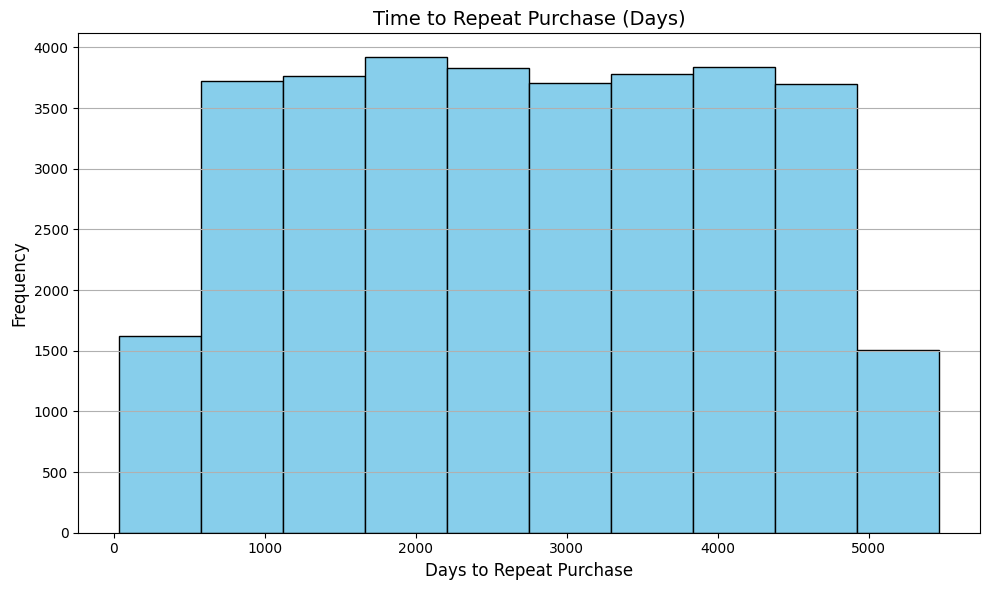

Average Time to Repeat Purchase: 2740.75 days


In [168]:
#Just repeat orders
repeat_purchases = cirkul[cirkul['IsRepeatOrder'] == 1]

#Days between FirstPurchaseDate and InteractionDate
repeat_purchases['DaysToRepeat'] = (repeat_purchases['InteractionDate'] - repeat_purchases['FirstPurchaseDate']).dt.days

plt.figure(figsize=(10, 6))
plt.hist(repeat_purchases['DaysToRepeat'], bins=10, color='skyblue', edgecolor='black')
plt.title('Time to Repeat Purchase (Days)', fontsize=14)
plt.xlabel('Days to Repeat Purchase', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Insight: Average Time to Repeat Purchase
average_days_to_repeat = repeat_purchases['DaysToRepeat'].mean()
print(f"Average Time to Repeat Purchase: {average_days_to_repeat:.2f} days")

#We are missing data from when a lot of customers who made their first purchase well before the scope of our data, which creates this massive skew (years!).

Average Time to Repeat Purchase (from 2023-01-01): 346.20 days


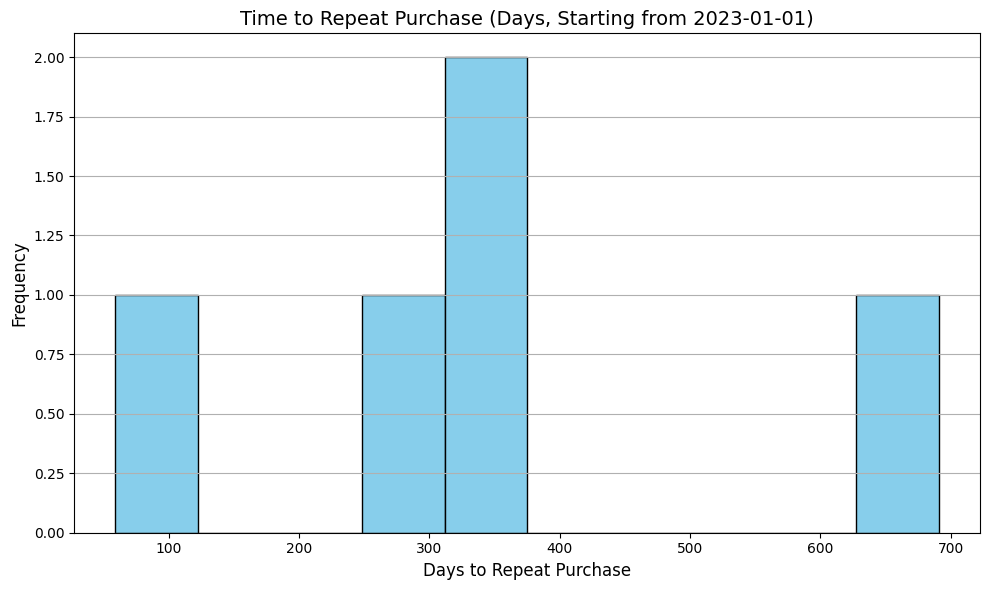

In [ ]:
#Filtering to just the first purchases within the frame we have data for, may not have enough
start_date_filter = pd.to_datetime('2023-01-01')
filtered_purchases = cirkul[
    (cirkul['FirstPurchaseDate'] >= start_date_filter) & (cirkul['IsRepeatOrder'] == 1)
]

#Calculate days between FirstPurchaseDate and InteractionDate
filtered_purchases['DaysToRepeat'] = (
    filtered_purchases['InteractionDate'] - filtered_purchases['FirstPurchaseDate']
).dt.days

average_days_to_repeat_filtered = filtered_purchases['DaysToRepeat'].mean()

#Note on avg. time
print(f"Average Time to Repeat Purchase (from 2023-01-01): {average_days_to_repeat_filtered:.2f} days")

plt.figure(figsize=(10, 6))
plt.hist(filtered_purchases['DaysToRepeat'], bins=10, color='skyblue', edgecolor='black')
plt.title('Time to Repeat Purchase (Days, Starting from 2023-01-01)', fontsize=14)
plt.xlabel('Days to Repeat Purchase', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# We only have  5 customers in the set to work with, no meaningful takeaway. This would IDEALLY be used as a way to ramp up targeted ads (email campaign, some way to pipe this into social media feeds in a targeted manner, etc.) to spend marketing dollars most effectively. Ideally ramping up marketing spends on customers that made their last purchase X days ago as they will likely need to make a purchase again soon.

Most Popular Flavor Sips:
     Flavor  Count
0  Cucumber   5132
1      Mint   5101
2     Lemon   4999
3     Berry   4938
4     Peach   4926


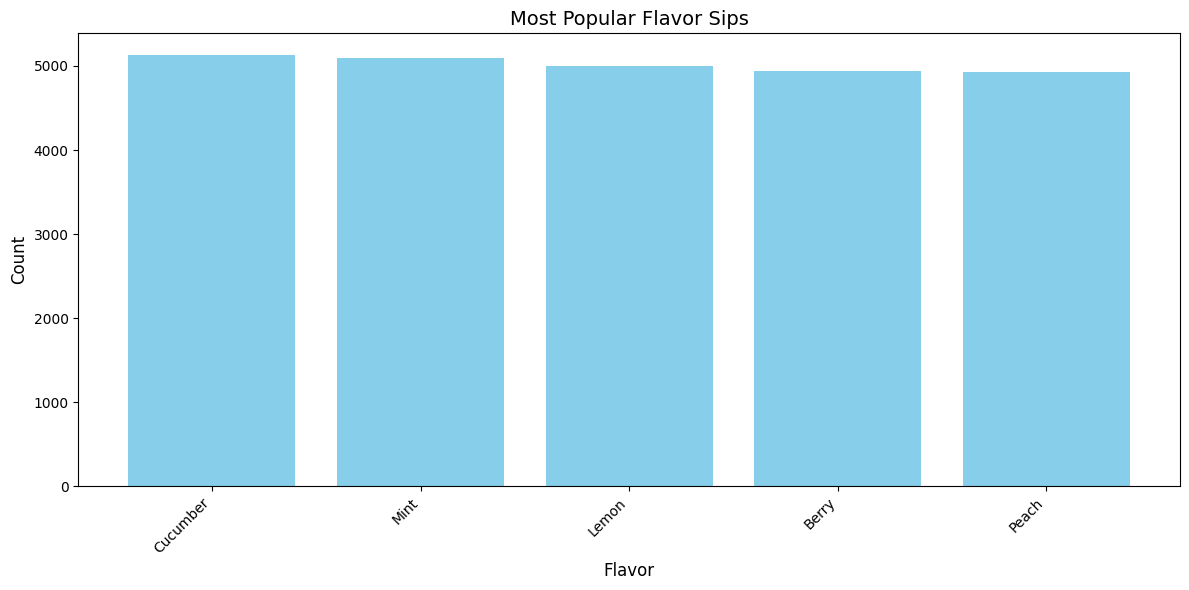

In [167]:
popular_flavors = cirkul['SipFlavorPurchased'].value_counts().reset_index()

popular_flavors.columns = ['Flavor', 'Count']

print("Most Popular Flavor Sips:")
print(popular_flavors)

plt.figure(figsize=(12, 6))
plt.bar(popular_flavors['Flavor'], popular_flavors['Count'], color='skyblue')
plt.title('Most Popular Flavor Sips', fontsize=14)
plt.xlabel('Flavor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# After some quick hitters let's try to end with some business-significant KPI Analysis
### Note: I have no real experience in eCommerce and tried to make some reaches/basic research on what I had and what I could create

In [ ]:
#Revenue by Product Category
revenue_by_category = cirkul.groupby('ProductCategory')['AmountSpent'].sum().reset_index()
revenue_by_category.columns = ['ProductCategory', 'TotalRevenue']

#Revenue by Acquisition Channel
revenue_by_channel = cirkul.groupby('AcquisitionChannel')['AmountSpent'].sum().reset_index()
revenue_by_channel.columns = ['AcquisitionChannel', 'TotalRevenue']

#Average Order Value (AOV)
total_revenue = cirkul['AmountSpent'].sum()
total_orders = cirkul[cirkul['QuantityPurchased'] > 0].shape[0]  # Count only orders with purchases
average_order_value = total_revenue / total_orders if total_orders > 0 else 0

#Cart Conversion Rate (In this case it is how many session IDs ended with a purchase)
total_sessions = cirkul.shape[0]
total_checkouts = cirkul[cirkul['Conversion'] == 1].shape[0]
cart_conversion_rate = (total_checkouts / total_sessions) * 100 if total_sessions > 0 else 0

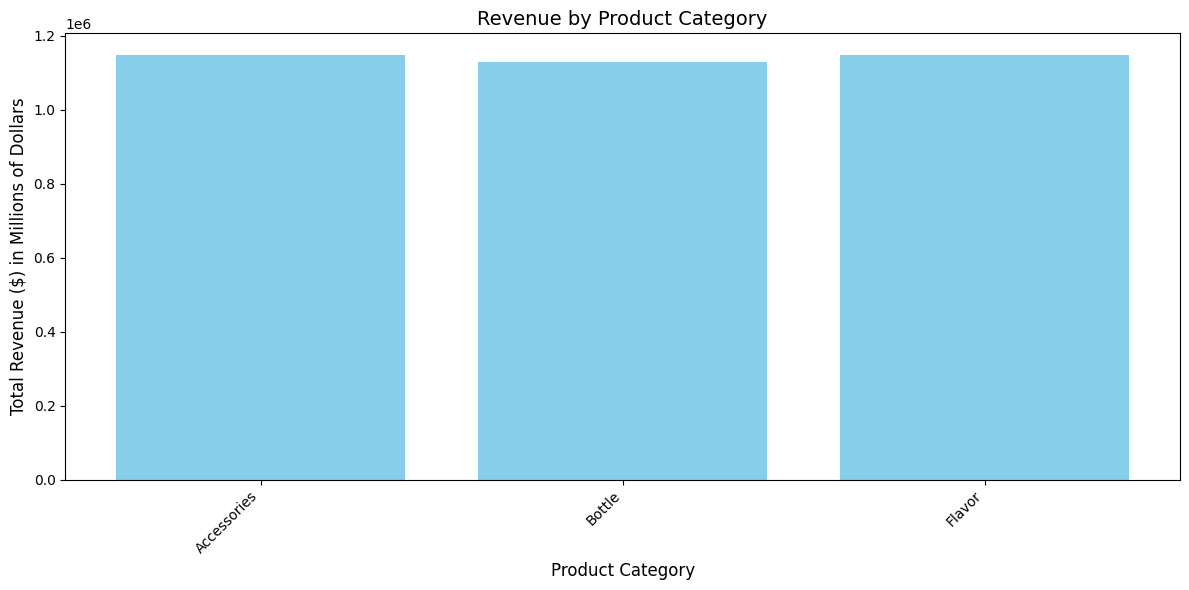

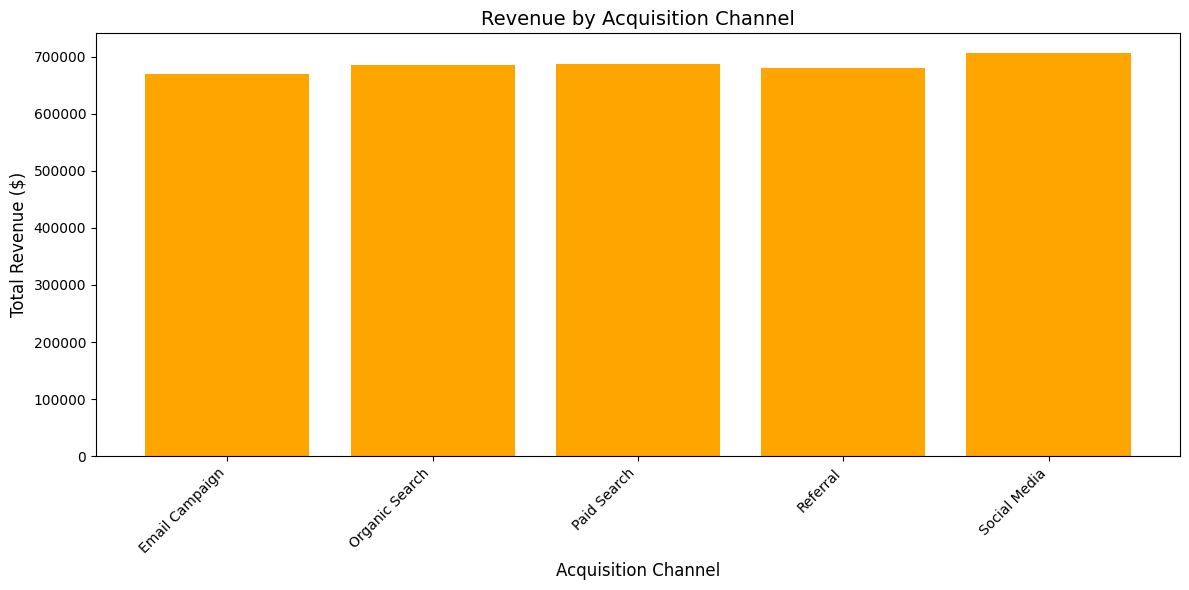

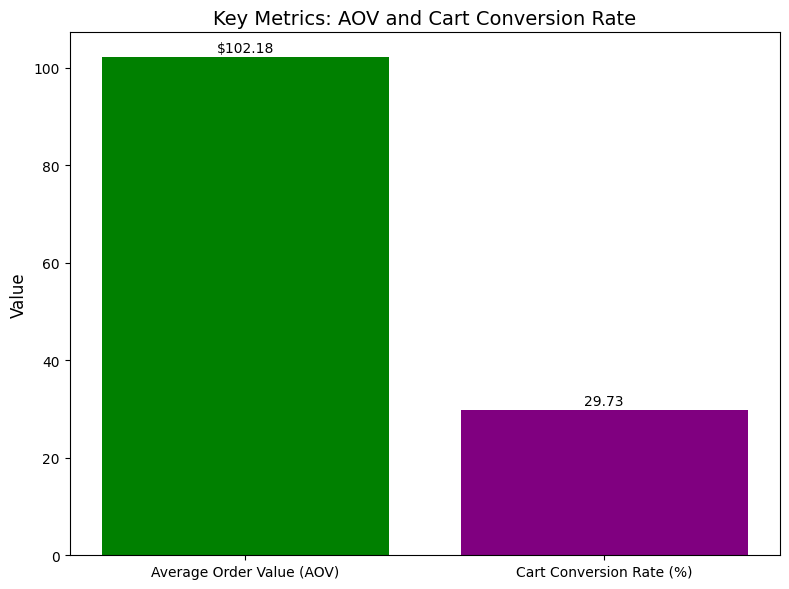

In [169]:
#Revenue by Product Category Viz
plt.figure(figsize=(12, 6))
plt.bar(revenue_by_category['ProductCategory'], revenue_by_category['TotalRevenue'], color='skyblue')
plt.title('Revenue by Product Category', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Revenue ($) in Millions of Dollars', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Revenue by Acquisition Channel Viz
plt.figure(figsize=(12, 6))
plt.bar(revenue_by_channel['AcquisitionChannel'], revenue_by_channel['TotalRevenue'], color='orange')
plt.title('Revenue by Acquisition Channel', fontsize=14)
plt.xlabel('Acquisition Channel', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#AOV and Cart Conversion Rate Viz
labels = ['Average Order Value (AOV)', 'Cart Conversion Rate (%)']
values = [average_order_value, cart_conversion_rate]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['green', 'purple'])
plt.title('Key Metrics: AOV and Cart Conversion Rate', fontsize=14)
plt.ylabel('Value', fontsize=12)

#Annotations
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{value:.2f}" if value < 100 else f"${value:.2f}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Ending note: I wanted to use this data to show off my capacity to work with and generate insights from data, but a Python Notebook isn't what I would leave as the standard in a production environment. This isn't something you can kick to a non-technical stakeholder and expect to get engagement. I would take the logic applied to creating these visuals and create an engaging and malleable handoff that I can supply to any manager, technical or not to add empirical support for decision making, and I have a quick demo with a side project to show what it could look like!